In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Study on the Football Statistics and the Correctness of the Odds
### by Kalin Primov

## Abstract
.......

## Introduction
The goal of this study is to see to what extend the odds, which bookmakers assign to games can be used in predicting the final outcome. The data with the odds is taken from *oddsportal* and the data with the games is taken from various sources. Also would be measured the accuracy of odds such as both teams to score, more or less than 2.5 goals and both team to or not to score. The data is for the five major leagues - La Liga, Premier League, Bundesliga, Ligue 1 and Seria A and we will see where and how the predictions and reality are different for the leagues.

## Data Manipulation

### Data Collection
The data is divided into 2 datasets in the '''ginf.csv''' is the data from the _odsportal_ with the odds for the games. The columns in the dataset are:
* id_odsp - unique game identifier
* link_odsp - link to oddsportal page
* adv_stats - boolean if the game has detailed event data
* data
* league
* season
* ht - home team
* at - away team
* fthg - full time home goals
* ftag - full time away goals
* odd_h - home win odds
* odd_d - draw odds
* odd_a - away win odds
* odd_over - over 2.5 goals odds
* odd_under - under 2.5 goals odds
* odd_bts - both teams to score odds
* odd_bts_n - both teams not to score odds

In the ```events.csv``` is the data from the events. We will use it to compare it with the data from ```ginf.csv``` and see if there are other factor, which affect games. The columns in the dataset are:

* id_odsp - unique game identifier
* id_event - unique identifier of event (id_odsp + sort_order)
* sort_order - chronological sequence of events in a game
* time - minutes of the game
* text - text commentary
* event_type - primary event. 11 unique events
* event_type2 - secondary event. 4 unique events
* side - 1-Home, 2-Away
* event_team - team that produced the event
* opponent - team that the event happened against
* player - name of the player involved in the main event
* player2 - name of player involved in secondary event
* player_in - substitude in
* player_out - substitude out
* shot_place - 13 possible placements of the shot
* shot_outcome
* is_goal
* location - location on the pitch
* bodypart
* assist_method
* situation
* fast_break

In [22]:
odds_data = pd.read_csv('data/ginf.csv')
events_data = pd.read_csv('data/events.csv')

Most of the stats are given index and the index corresponds to the dictionary. In the dictionary is the full meaning if the values in the columns.

In [23]:
encoding = pd.read_csv('data/dictionary.txt', sep='\t', index_col=0, names=('id', 'event_type'), header=None)
event_type=encoding[1:12]
event_type_2=encoding[14:18]
side=encoding[19:21]
shot_place=encoding[22:35]
shot_outcome=encoding[36:40]
location=encoding[41:60]
bodypart=encoding[61:64]
assist_method=encoding[65:70]
situition=encoding[71:75]

In [5]:
event_type

,event_type
id,
0,Announcement
1,Attempt
2,Corner
3,Foul
4,Yellow card
5,Second yellow card
6,Red card
7,Substitution
8,Free kick won


In [6]:
event_type_2

,event_type
id,
12,Key Pass
13,Failed through ball
14,Sending off
15,Own goal


In [7]:
side

,event_type
id,
1,Home
2,Away


In [8]:
shot_place

,event_type
id,
1,Bit too high
2,Blocked
3,Bottom left corner
4,Bottom right corner
5,Centre of the goal
6,High and wide
7,Hits the bar
8,Misses to the left
9,Misses to the right


In [9]:
shot_outcome

,event_type
id,
1,On target
2,Off target
3,Blocked
4,Hit the bar


In [10]:
location

,event_type
id,
1,Attacking half
2,Defensive half
3,Centre of the box
4,Left wing
5,Right wing
6,Difficult angle and long range
7,Difficult angle on the left
8,Difficult angle on the right
9,Left side of the box


In [11]:
bodypart

,event_type
id,
1,right foot
2,left foot
3,head


In [12]:
assist_method

,event_type
id,
0,None
1,Pass
2,Cross
3,Headed pass
4,Through ball


In [13]:
situition

,event_type
id,
1,Open play
2,Set piece
3,Corner
4,Free kick


### General Data Manipulation
Lets modify the column names, sio they are a bit more meaningful and drop some of the column, which we will not use.

## When Goals are Scored
Lets see when the teams score moast and does this corrensponds to the odds.

24446


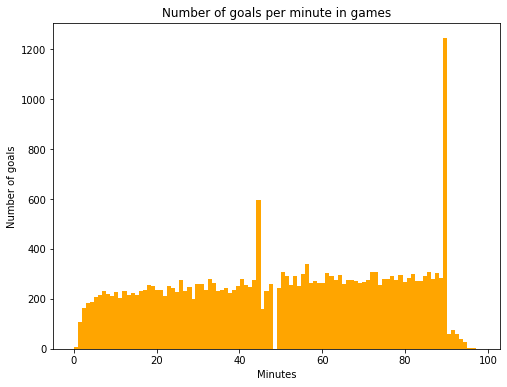

In [24]:
events_data['is_goal'] = events_data['is_goal'].astype('bool')
goals = events_data[events_data['is_goal']]

substitude = events_data[events_data['is_goal']]
fig=plt.figure(figsize=(8,6))
plt.hist(goals.time, width=1, bins=100, color='orange')
plt.xlabel('Minutes')
plt.ylabel('Number of goals')
plt.title('Number of goals per minute in games')
plt.show()

We can easily see spikes in around 45-th and 90-th minute, those are mainly because of the way data is reported in the games. Goals in the extra time are reported in the 45-th and 90-th minute respectively and because of that the spikes exist. Given that, lets see how many more goals are scored in the second half compared to the first half.

In [15]:
goals_first_half = np.size(goals[goals.time <= 45])
goals_second_half = np.size(goals[goals.time <= 90])
print((goals_second_half/goals_first_half))

2.2502792256142965


Out of those goals the distrubution home/away goals are as follow:

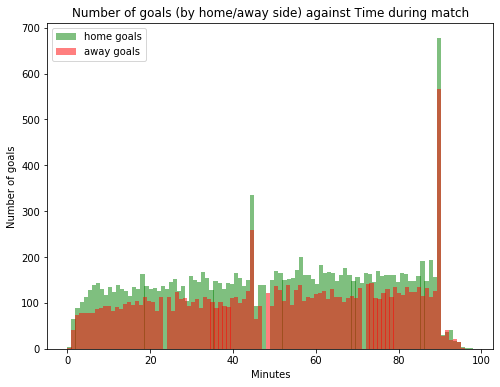

In [16]:
fig=plt.figure(figsize=(8,6))
plt.hist(goals[goals['side']==1]['time'], width=1, bins=100, color='green', label='home goals', alpha=0.5)   
plt.hist(goals[goals['side']==2]['time'], width=1, bins=100, color='red', label='away goals', alpha=0.5) 
plt.xlabel('Minutes')
plt.ylabel('Number of goals')
plt.title('Number of goals (by home/away side) against Time during match')
plt.legend()
plt.show()

For every minute more goals are scored by the home team compared to the away team. This supports the general notion, that the home team has the advantage. In the game info the mean odds for the home team and the away are as follow:

### How goals are scored
Interessting statistic will be also how goals are scored

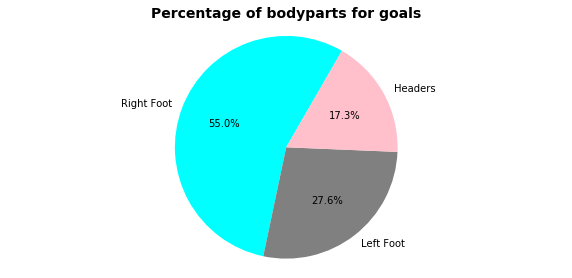

In [17]:
def show_pie_chart_bodyparts(goals_df, title='Percentage of bodyparts for goals'):
    """
    Shows a pie chart as a subplot of the 
    @input goals_df - datafreame with the goals. Muss have the column bodupart
    @input title: default = 'Percentage of bodyparts for goals' - title of the pie chart
    @output - none
    """
    plt.subplot(2,1,1)
    labels=['Right Foot', 'Left Foot', 'Headers']
    sizes=[goals_df[goals_df['bodypart']==1].shape[0], goals_df[goals_df['bodypart']==2].shape[0], goals_df[goals_df['bodypart']==3].shape[0]]
    colors=['cyan', 'grey', 'pink']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=60)
    plt.axis('equal')
    plt.title(title, fontsize=14, fontweight="bold")
    fig=plt.gcf() 
    fig.set_size_inches(10,10)
    plt.show()
show_pie_chart_bodyparts(goals)

The logic is quite clear, as most of the players are right-footed. The percentages look a bit different, when we see how they go in the different leagues:

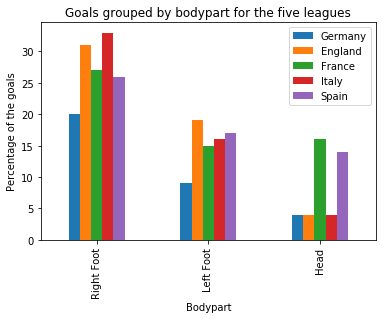

In [31]:
goals = goals.assign(league = odds_data['league'])
grouped_goals = goals.groupby('league')
index = ['Right foot', 'Left foor', 'Head']
ax = grouped_goals.bodypart.value_counts().unstack(0).plot.bar()
ax.legend(['Germany', 'England', 'France', 'Italy', 'Spain'])
plt.xticks(np.arange(3), ('Right Foot', 'Left Foot', 'Head'))
plt.title('Goals grouped by bodypart for the five leagues')
plt.ylabel("Percentage of the goals")
plt.xlabel("Bodypart")
plt.show()

Surprisingly here most goals with head are scored in France and Spain, but in countries, which are famous for more "physical" approach as England and Germany the statistics are very different. Which comfirms the data in the research made by Edward Nsolo, Patric Lambrix and Niklas Carlsson - [Player valuation in European football](https://www.ida.liu.se/~nikca89/papers/mlsa18-football.pdf)

        id_odsp     id_event  sort_order  time  \
13    UFot0hit/   UFot0hit14          14    17   
50    UFot0hit/   UFot0hit51          51    49   
517   GUOdmtII/   GUOdmtII35          35    34   
990   UBZQ4smg/   UBZQ4smg50          50    33   
1036  UBZQ4smg/   UBZQ4smg96          96    74   
1270  WQGN5NXn/   WQGN5NXn83          83    61   
1409  x4HJ63It/  x4HJ63It101         101    75   
1563  xtklbWLh/   xtklbWLh17          17    15   
1733  zeViBqAP/   zeViBqAP82          82    74   
2190  SEqvxt5j/   SEqvxt5j58          58    64   
2348  bw0Yaqcc/    bw0Yaqcc8           8    12   
2956  lShocssG/   lShocssG63          63    64   
3175  t2kwa3C3/   t2kwa3C364          64    63   
3215  t2kwa3C3/  t2kwa3C3104         104    90   
3281  UPAXkaZk/   UPAXkaZk66          66    71   
3579  x8cIHKWb/   x8cIHKWb63          63    71   
4234  WzGcd1dM/   WzGcd1dM93          93    80   
4827  ljHSD2Rd/   ljHSD2Rd22          22    17   
4848  ljHSD2Rd/   ljHSD2Rd43          43    34   


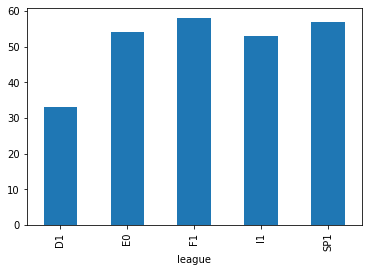

In [33]:
# ax = grouped_goals.size().plot.bar()
# for key, item in grouped_goals:
#     print(grouped_goals.get_group(key), "\n\n")
# plt.xticks(np.arange(5), ('Germany', 'England', 'France', 'Italy', 'Spain'))
# plt.title('Goals in the Leagues')
# plt.ylabel("Goals")
# plt.xlabel("League")
# plt.show()

Lets see how this compares to the substitutions made

In [20]:
substitution=events_data[events_data["event_type"]==7]

Text(0.5, 1.0, 'Number of substitutions against Time during match')

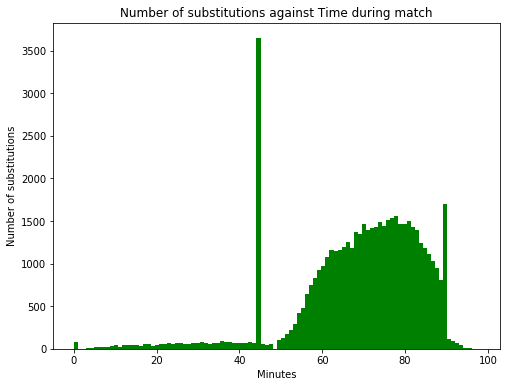

In [21]:
fig=plt.figure(figsize=(8,6))
bins = 100
plt.hist(substitution.time, bins, width=1, color="green")   
plt.xlabel("Minutes")
plt.ylabel("Number of substitutions")
plt.title("Number of substitutions against Time during match")